In [1]:
!pip install psycopg2-binary sqlalchemy pandas matplotlib seaborn missingno

In [37]:
import pandas as pd
import numpy as np

import psycopg2
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px

plt.style.use("default")

In [21]:
#inputting details from the user 
DB_HOST = input("Enter DB host (default: localhost): ") or "localhost"
DB_PORT = input("Enter DB port (default: 5432): ") or "5432"
DB_NAME = input("Enter database name: ")
DB_USER = input("Enter database username: ")
DB_PASSWORD = input("Enter database password: ")

CSV_PATH = input("Enter full CSV file path: ")
TABLE_NAME = input("Enter table name to create in Postgres: ")

Enter DB host (default: localhost):  localhost
Enter DB port (default: 5432):  5432
Enter database name:  precipitation
Enter database username:  VarshaBalip
Enter database password:  APDV#24331710
Enter full CSV file path:  C:\Users\LENOVO\OneDrive\Desktop\apdv_precepitation\MTM05.20251202T161205.csv
Enter table name to create in Postgres:  precipitation


In [22]:
engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

print("Connected to PostgreSQL successfully")

Connected to PostgreSQL successfully


In [23]:
df = pd.read_csv(CSV_PATH)

print("Dataset loaded successfully")
print("Shape:", df.shape)
df.head()

Dataset loaded successfully
Shape: (9480, 5)


,Statistic Label,Month,Meteorological Weather Station,UNIT,VALUE
0,Precipitation Amount,1960 January,Malin Head,Millimetres,113.0
1,Precipitation Amount,1960 January,Claremorris,Millimetres,113.9
2,Precipitation Amount,1960 January,Valentia Observatory,Millimetres,164.4
3,Precipitation Amount,1960 January,Belmullet,Millimetres,101.0
4,Precipitation Amount,1960 January,Shannon Airport,Millimetres,83.1


In [24]:
df.to_sql(
    name=TABLE_NAME,
    con=engine,
    if_exists="replace",
    index=False
)

print(f"Data uploaded to PostgreSQL table: {TABLE_NAME}")

Data uploaded to PostgreSQL table: precipitation


In [25]:
#extracting the dataset back from postgres to df_pg
query = f"SELECT * FROM {TABLE_NAME};"
df_pg = pd.read_sql(query, engine)

print("Data fetched from PostgreSQL")
print("Shape:", df_pg.shape)
df_pg.head()

Data fetched from PostgreSQL
Shape: (9480, 5)


,Statistic Label,Month,Meteorological Weather Station,UNIT,VALUE
0,Precipitation Amount,1960 January,Malin Head,Millimetres,113.0
1,Precipitation Amount,1960 January,Claremorris,Millimetres,113.9
2,Precipitation Amount,1960 January,Valentia Observatory,Millimetres,164.4
3,Precipitation Amount,1960 January,Belmullet,Millimetres,101.0
4,Precipitation Amount,1960 January,Shannon Airport,Millimetres,83.1


In [26]:
pd.read_sql(
    """
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'public';
    """,
    engine
)


,table_name
0,Precipitation
1,precipitation


In [27]:
#dataset overview
df_pg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9480 entries, 0 to 9479
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Statistic Label                 9480 non-null   object 
 1   Month                           9480 non-null   object 
 2   Meteorological Weather Station  9480 non-null   object 
 3   UNIT                            9480 non-null   object 
 4   VALUE                           7734 non-null   float64
dtypes: float64(1), object(4)
memory usage: 370.4+ KB


In [29]:
df_clean = df_pg
# Explicit datetime parsing
df_clean["Month_dt"] = pd.to_datetime(
    df_pg["Month"],
    format="%Y %B",   # e.g., "1960 January"
    errors="coerce"
)
#Feature engineering
df_clean["Year"] = df_pg["Month_dt"].dt.year
df_clean["Month_Num"] = df_pg["Month_dt"].dt.month
df_clean["Month_Name"] = df_pg["Month_dt"].dt.month_name()
df_clean.head()

,Statistic Label,Month,Meteorological Weather Station,UNIT,VALUE,Month_dt,Year,Month_Num,Month_Name
0,Precipitation Amount,1960 January,Malin Head,Millimetres,113.0,1960-01-01,1960,1,January
1,Precipitation Amount,1960 January,Claremorris,Millimetres,113.9,1960-01-01,1960,1,January
2,Precipitation Amount,1960 January,Valentia Observatory,Millimetres,164.4,1960-01-01,1960,1,January
3,Precipitation Amount,1960 January,Belmullet,Millimetres,101.0,1960-01-01,1960,1,January
4,Precipitation Amount,1960 January,Shannon Airport,Millimetres,83.1,1960-01-01,1960,1,January


In [31]:
#assign season by month number
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df_clean["Season"] = df_pg["Month_Num"].apply(get_season) #creating a new column indicating the season for each record
coastal_stations = ["Malin Head", "Belmullet", "Valentia Observatory"] #list of weather stations located near the coast

df_clean["Location_Type"] = df_pg["Meteorological Weather Station"].apply(
    lambda x: "Coastal" if x in coastal_stations else "Inland" 
) #classification stations as Coastal or Inland?

In [32]:
#filtering data from 2009 to 2023
df_filtered = df_clean[
    (df_clean["Month_dt"] >= "2009-01-01") &
    (df_clean["Month_dt"] <= "2023-12-31")
].copy()

df_filtered["Year"].min(), df_filtered["Year"].max()

(np.int32(2009), np.int32(2023))

In [33]:
df_filtered.shape

(2160, 11)

In [34]:
df_filtered.info() #check number of rows, cols. and datatypes

<class 'pandas.core.frame.DataFrame'>
Index: 2160 entries, 7056 to 9215
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Statistic Label                 2160 non-null   object        
 1   Month                           2160 non-null   object        
 2   Meteorological Weather Station  2160 non-null   object        
 3   UNIT                            2160 non-null   object        
 4   VALUE                           2151 non-null   float64       
 5   Month_dt                        2160 non-null   datetime64[ns]
 6   Year                            2160 non-null   int32         
 7   Month_Num                       2160 non-null   int32         
 8   Month_Name                      2160 non-null   object        
 9   Season                          2160 non-null   object        
 10  Location_Type                   2160 non-null   object        
dtypes: dat

In [35]:
df_filtered["Meteorological Weather Station"].value_counts() #confirming station 

Meteorological Weather Station
Malin Head              180
Claremorris             180
Valentia Observatory    180
Belmullet               180
Shannon Airport         180
Dublin Airport          180
Mullingar               180
Cork Airport            180
Casement                180
Phoenix Park            180
Roches Point            180
Markree                 180
Name: count, dtype: int64

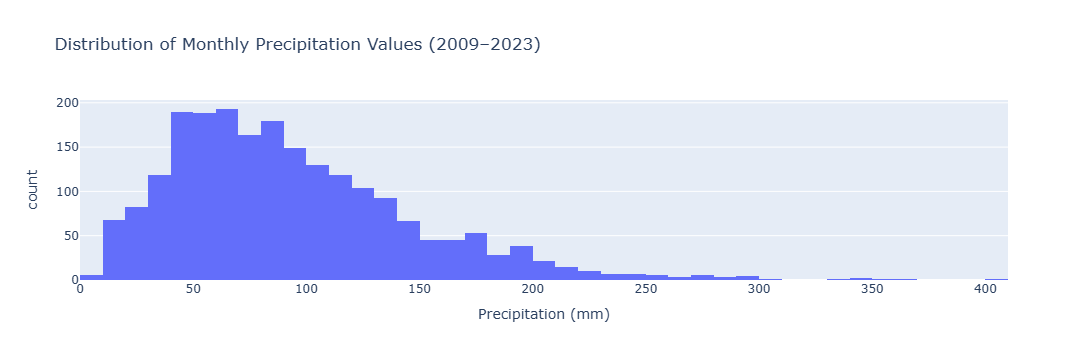

In [38]:
#EDA
#Distribution for precipitation - extreme values and skewness
fig_eda = px.histogram(
    df_filtered,
    x="VALUE",
    nbins=40,
    title="Distribution of Monthly Precipitation Values (2009–2023)",
    labels={"VALUE": "Precipitation (mm)"}
)
fig_eda.show()

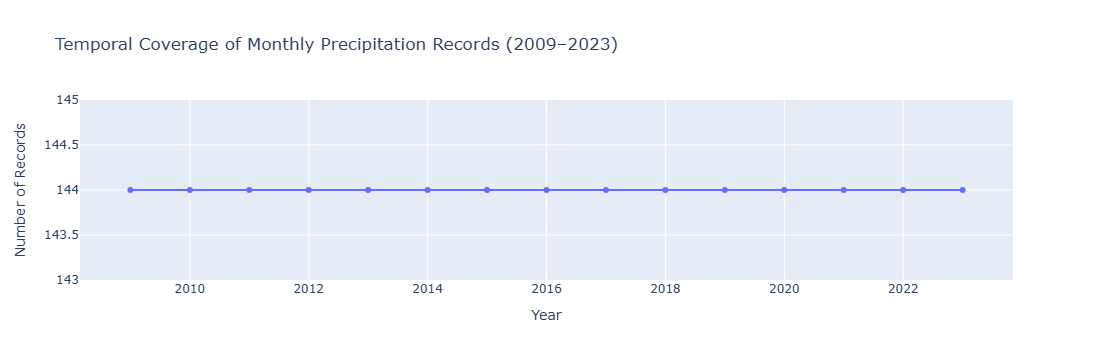

In [39]:
#line plot - highlights the year-wise availability of precipitation records.
yearly_coverage = (
    df_filtered
    .groupby("Year") #grouping the data yearwise
    .size() #count records in each year
    .reset_index(name="Record_Count") #storing the count in new column
) #yearwise record count

fig_eda_line = px.line(
    yearly_coverage,
    x="Year",
    y="Record_Count",
    markers=True, 
    title="Temporal Coverage of Monthly Precipitation Records (2009–2023)",
    labels={
        "Record_Count": "Number of Records",
        "Year": "Year"
    }
)
fig_eda_line.show()

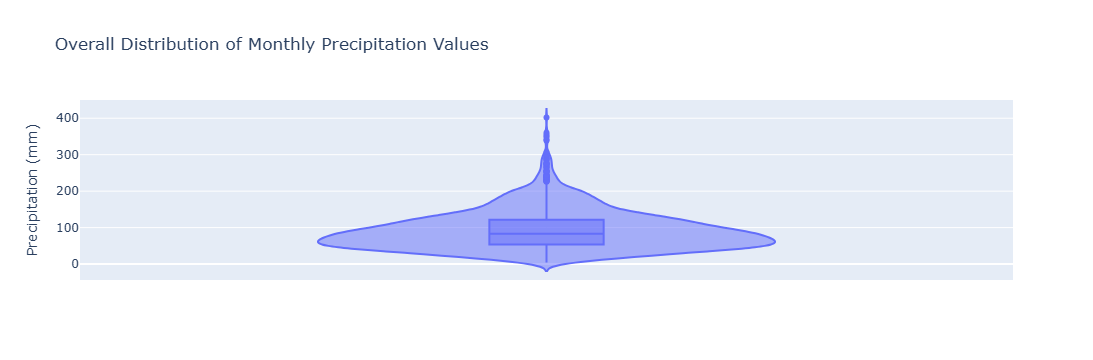

In [40]:
#values indicating that while most observations cluster around moderate rainfall levels
fig_violin = px.violin(
    df_filtered,
    y="VALUE",
    box=True,
    points="outliers",
    title="Overall Distribution of Monthly Precipitation Values",
    labels={"VALUE": "Precipitation (mm)"}
)

fig_violin.show()

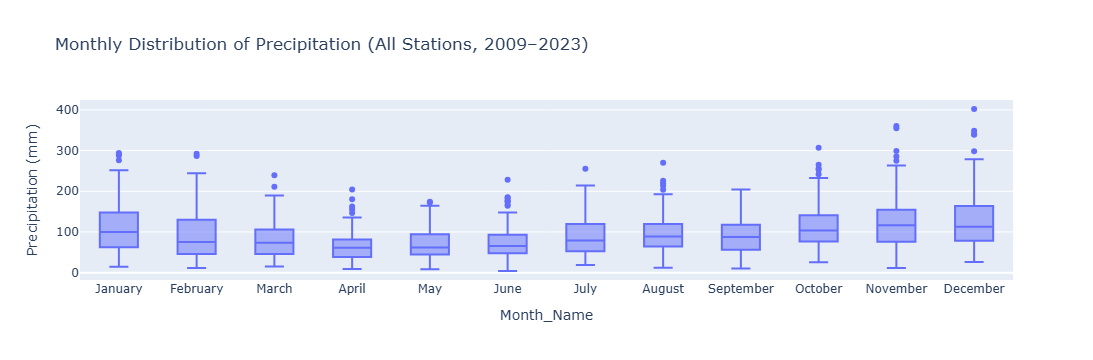

In [41]:
#Seasonal intuition without station comparison
fig_month = px.box(
    df_filtered,
    x="Month_Name",
    y="VALUE",
    title="Monthly Distribution of Precipitation (All Stations, 2009–2023)",
    labels={"VALUE": "Precipitation (mm)"},
)

fig_month.update_xaxes(
    categoryorder="array",
    categoryarray=[
        "January","February","March","April","May","June",
        "July","August","September","October","November","December"
    ]
)
fig_month.show()

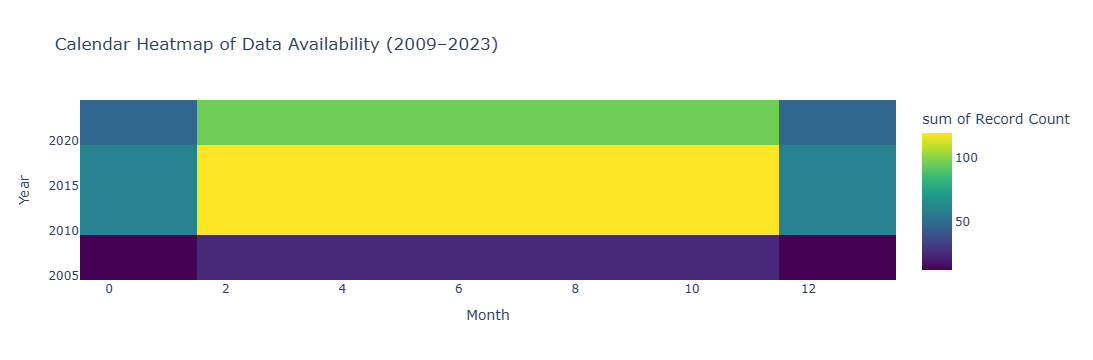

In [43]:
#visualizes temporal density and detect missing values
calendar_data = (
    df_filtered
    .groupby(["Year", "Month_Num"])
    .size()
    .reset_index(name="Count")
)

fig_calendar = px.density_heatmap(
    calendar_data,
    x="Month_Num",
    y="Year",
    z="Count",
    color_continuous_scale="Viridis",
    title="Calendar Heatmap of Data Availability (2009–2023)",
    labels={
        "Month_Num": "Month",
        "Count": "Record Count"
    }
)

fig_calendar.show()

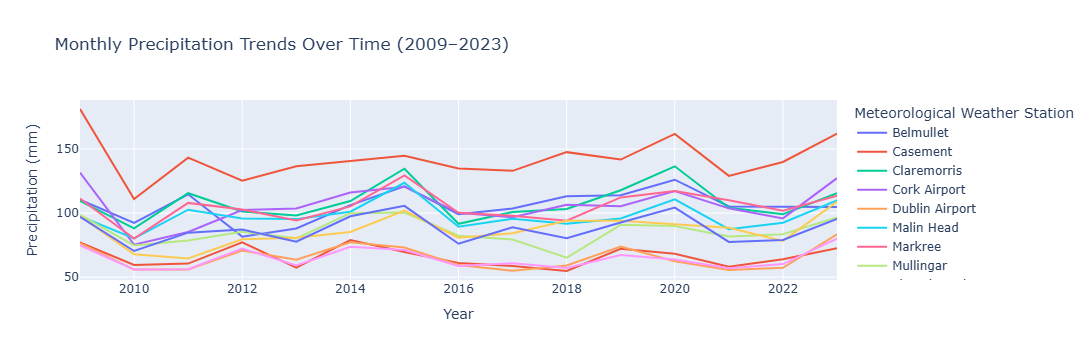

In [44]:
rq1_data = df_filtered.groupby(
    ["Year", "Meteorological Weather Station"] #group by year and station
)["VALUE"].mean().reset_index() #calculate mean precipitation
#line plot - compare precipitation trends across stations
fig_rq1 = px.line(
    rq1_data,
    x="Year",
    y="VALUE",
    color="Meteorological Weather Station",
    title="Monthly Precipitation Trends Over Time (2009–2023)",
    labels={
        "VALUE": "Precipitation (mm)",
        "Year": "Year"
    }
)
fig_rq1.show()

### RQ2 Are there significant differences in precipitation patterns between coastal and inland weather stations in Ireland between January 2009 and December 2023?
Purpose: To compare spatial rainfall behaviour influenced by geographical location.
This graph or plot helps to check the amount of rainfall that occurred in the coastal and inland meteorological stations for the months of January 2009 to December 2023. It is quite obvious from the box plot that the amount of rainfall is greater in the coastal meteorological stations as compared to the inland meteorology stations. This is also evident from the graph plot. Since the average amount of rainfall is higher in the coastal meteorological stations. This may be attributed to the influence of the Atlantic weather system that exerts its influence over the coast of Ireland.

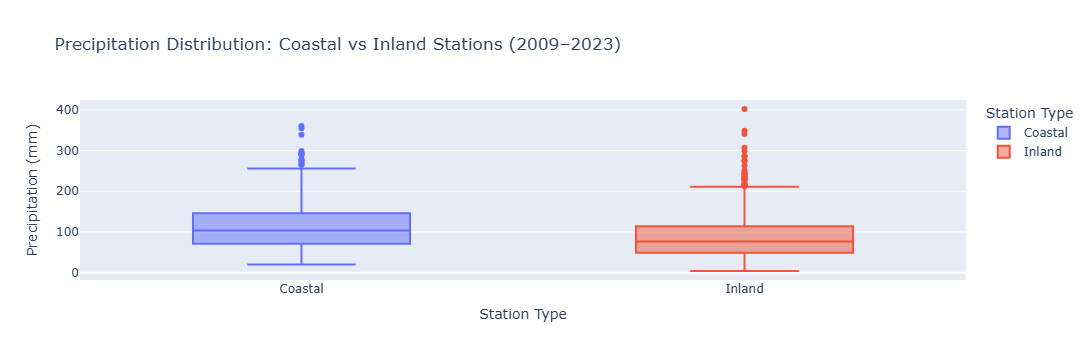

In [45]:
#assuming and defining coastal stations 
coastal_stations = [
    "Malin Head", 
    "Belmullet", 
    "Valentia Observatory"
]

#giving a location type
df_filtered["Location_Type"] = df_filtered["Meteorological Weather Station"].apply(
    lambda x: "Coastal" if x in coastal_stations else "Inland"
)

df_filtered["Location_Type"].value_counts() #checking

avg_precip_location = df_filtered.groupby(
    "Location_Type"
)["VALUE"].mean().reset_index()

fig_box = px.box(
    df_filtered,
    x="Location_Type",
    y="VALUE",
    color="Location_Type",
    title="Precipitation Distribution: Coastal vs Inland Stations (2009–2023)",
    labels={
        "VALUE": "Precipitation (mm)",
        "Location_Type": "Station Type"
    }
)

fig_box.show()

### RQ3- How does seasonal precipitation vary across Irish meteorological stations between January 2009 and December 2023?
Purpose: To analyse seasonal dominance and regional climatic differences. This graph/plot illustrates seasonal precipitation patterns across Irish meteorological stations between January 2009 and December 2023. Winter consistently records the highest average precipitation across most stations, while summer exhibits comparatively lower rainfall levels. Seasonal differences are evident across all locations, highlighting the strong influence of seasonal climatic cycles on precipitation behaviour in Ireland.

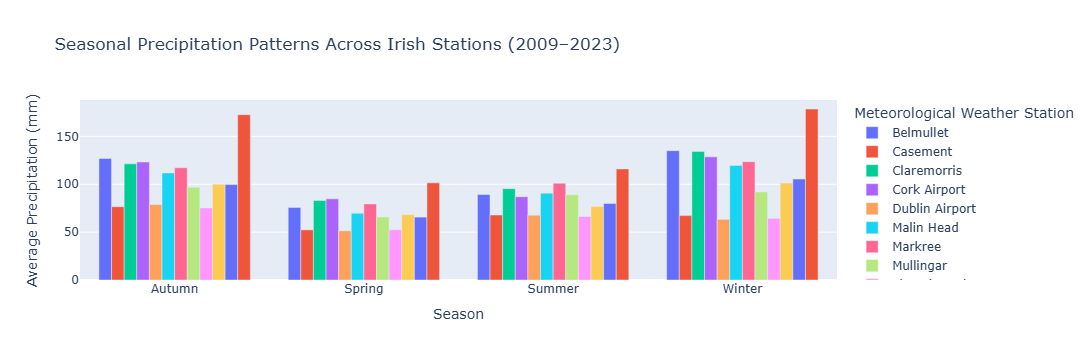

In [46]:
#RQ3 How does seasonal precipitation vary across Irish meteorological stations between January 2009 and December 2023?
df_filtered["Season"].value_counts() #checking

seasonal_data = df_filtered.groupby(
    ["Season", "Meteorological Weather Station"]
)["VALUE"].mean().reset_index()

seasonal_data.head()

fig_season = px.bar(
    seasonal_data,
    x="Season",
    y="VALUE",
    color="Meteorological Weather Station",
    barmode="group",
    title="Seasonal Precipitation Patterns Across Irish Stations (2009–2023)",
    labels={
        "VALUE": "Average Precipitation (mm)",
        "Season": "Season"
    }
)

fig_season.show()

### RQ4 Which meteorological stations exhibit the highest variability in precipitation between January 2009 and December 2023?
Purpose: To identify regions with unstable or extreme rainfall behaviour.
This graph or plot is showing the amount of rainfall variability of Irish meteorological stations between January 2009 and December 2023 through the standard deviation of rainfall for each month. 
This variability of rainfall is usually high in some of these stations, for example, those along the coast, meaning that there is more fluctuation of rainfall in such areas. 
A number of the inland stations record low rainfall variability.

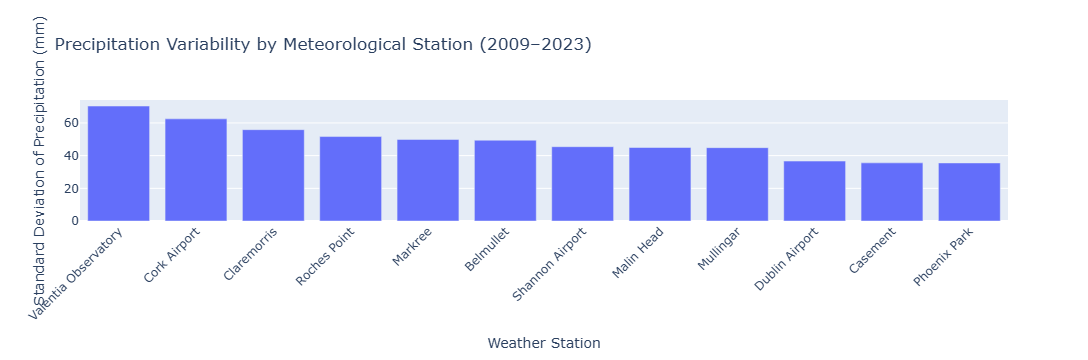

In [47]:
variability_data = df_filtered.groupby(
    "Meteorological Weather Station"
)["VALUE"].std().reset_index()

variability_data.rename(
    columns={"VALUE": "Precipitation_Variability"},
    inplace=True
)

# print(variability_data)

variability_data = variability_data.sort_values(
    by="Precipitation_Variability",
    ascending=False
)

fig_var = px.bar(
    variability_data,
    x="Meteorological Weather Station",
    y="Precipitation_Variability",
    title="Precipitation Variability by Meteorological Station (2009–2023)",
    labels={
        "Meteorological Weather Station": "Weather Station",
        "Precipitation_Variability": "Standard Deviation of Precipitation (mm)"
    }
)

fig_var.update_layout(
    xaxis_tickangle=-45
)

fig_var.show()

### RQ5 Are extreme precipitation events clustered in specific years or meteorological stations between January 2009 and December 2023?
To detect unusual rainfall events and assess potential climate risk indicators. The extremes were defined as events above the 95th percentile of monthly precipitation totals. 
This figure shows the distribution of extremes (temporal and spatial) from January 2009 to December 2023. 
It is observed that extreme precipitation events occur neither temporally nor spatially uniformly distributed. 
Some years and stations exhibit more concentration of extreme rainfall events than others. 
Alternatively, as mentioned earlier, evidence of clustering points out periods where hydrological risk heightens 
and underlines the necessity for monitoring precipitation extremes.

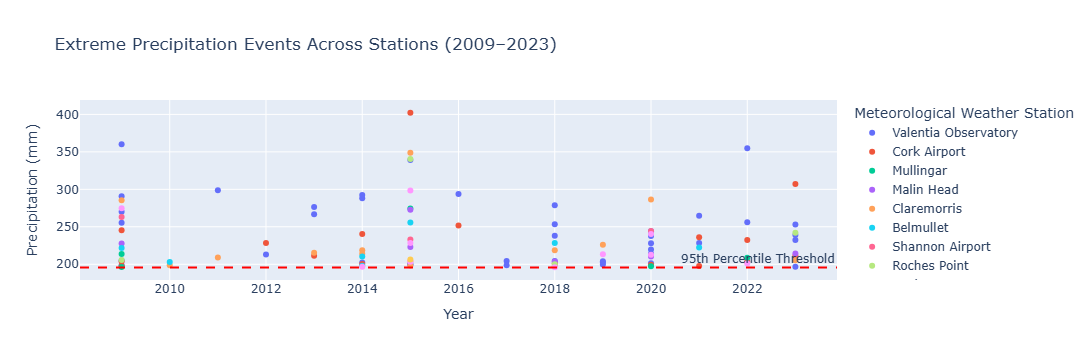

In [48]:
# Define extreme precipitation threshold (95th percentile)
extreme_threshold = df_filtered["VALUE"].quantile(0.95)

# print(extreme_threshold)

extreme_events = df_filtered[
    df_filtered["VALUE"] > extreme_threshold
].copy()

extreme_events.head()

fig_extreme = px.scatter(
    extreme_events,
    x="Year",
    y="VALUE",
    color="Meteorological Weather Station",
    title="Extreme Precipitation Events Across Stations (2009–2023)",
    labels={
        "VALUE": "Precipitation (mm)",
        "Year": "Year"
    }
)

fig_extreme.add_hline(
    y=extreme_threshold, #Adding threshold 
    line_dash="dash",
    line_color="red",
    annotation_text="95th Percentile Threshold"
)
fig_extreme.show()